In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn import metrics

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
df= pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
df_missing = df.isnull().sum()
df_missing = df_missing.sort_values(ascending=False)

In [5]:
df_missing = df_missing[df_missing>0]
df_train = df.drop(df_missing.index.tolist(), axis=1)
df_train.isnull().sum().max()

0

In [6]:
numeric = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
numeric.remove('Id')
numeric.remove('SalePrice')

categorical = [f for f in df_train.columns if df_train.dtypes[f] == 'object']

In [7]:
category_maps = []
def add_rank_feature(feature_name, rank_feature_name):
    df_order = pd.DataFrame()
    df_order['val'] = df_train[feature_name].unique()
    df_order.index = df_order.val
    
    df_order['mean_price'] = df_train[[feature_name, 'SalePrice']].groupby(feature_name).mean()['SalePrice']
    df_order['rank'] = range(1, len(df_order)+1)
    df_order = df_order['rank'].to_dict()
    
    category_maps.append(df_order)
    
    df_train[rank_feature_name] = df_train.apply(lambda x: df_order[x[feature_name]], axis=1)

In [8]:
rank_features = []
for feature_name in categorical:
    rank_feature_name = feature_name + "_rank"
    print(feature_name, "-->", rank_feature_name)
    
    add_rank_feature(feature_name, rank_feature_name)
    rank_features.append(rank_feature_name)

MSZoning --> MSZoning_rank
Street --> Street_rank
LotShape --> LotShape_rank
LandContour --> LandContour_rank
Utilities --> Utilities_rank
LotConfig --> LotConfig_rank
LandSlope --> LandSlope_rank
Neighborhood --> Neighborhood_rank
Condition1 --> Condition1_rank
Condition2 --> Condition2_rank
BldgType --> BldgType_rank
HouseStyle --> HouseStyle_rank
RoofStyle --> RoofStyle_rank
RoofMatl --> RoofMatl_rank
Exterior1st --> Exterior1st_rank
Exterior2nd --> Exterior2nd_rank
ExterQual --> ExterQual_rank
ExterCond --> ExterCond_rank
Foundation --> Foundation_rank
Heating --> Heating_rank
HeatingQC --> HeatingQC_rank
CentralAir --> CentralAir_rank
KitchenQual --> KitchenQual_rank
Functional --> Functional_rank
PavedDrive --> PavedDrive_rank
SaleType --> SaleType_rank
SaleCondition --> SaleCondition_rank


In [9]:
df_processed = df_train[rank_features + numeric]
df_processed['SalePrice'] = df_train['SalePrice']
df_processed

/var/folders/jt/n2n3tkp50_5g28q3q_g8rjdr0000gn/T/ipykernel_74600/2518916841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['SalePrice'] = df_train['SalePrice']


,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,1,1,1,1,1,1,1,1,1,...,0,61,0,0,0,0,0,2,2008,208500
1,1,1,1,1,1,2,1,2,2,1,...,298,0,0,0,0,0,0,5,2007,181500
2,1,1,2,1,1,1,1,1,1,1,...,0,42,0,0,0,0,0,9,2008,223500
3,1,1,2,1,1,3,1,3,1,1,...,0,35,272,0,0,0,0,2,2006,140000
4,1,1,2,1,1,2,1,4,1,1,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1,1,1,1,1,1,1,18,1,1,...,0,40,0,0,0,0,0,8,2007,175000
1456,1,1,1,1,1,1,1,7,1,1,...,349,0,0,0,0,0,0,2,2010,210000
1457,1,1,1,1,1,1,1,3,1,1,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1,1,1,1,1,1,1,12,1,1,...,366,0,112,0,0,0,0,4,2010,142125


In [10]:
corrmat = df_processed.corr()

<AxesSubplot:>

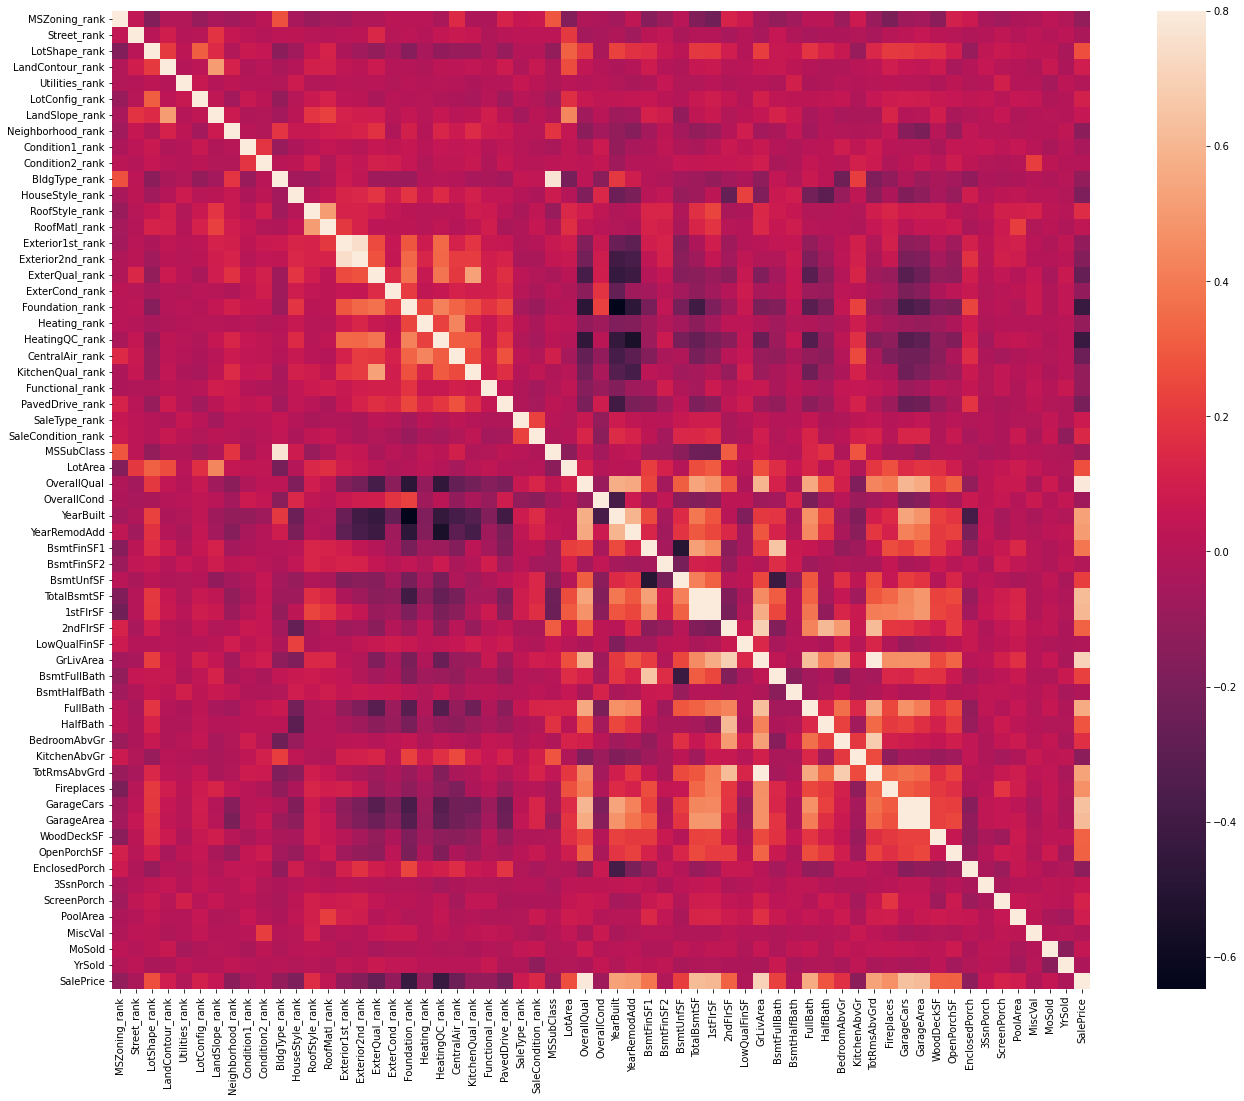

In [11]:
f, ax = plt.subplots(figsize=(24, 18))
sns.heatmap(corrmat, vmax=0.8, square=True)

In [12]:
df_features = corrmat.sort_values(by=['SalePrice'])['SalePrice']
df_features[:-1]

Foundation_rank      -0.429678
HeatingQC_rank       -0.427649
ExterQual_rank       -0.265015
CentralAir_rank      -0.251328
PavedDrive_rank      -0.208954
HouseStyle_rank      -0.188688
Exterior2nd_rank     -0.164716
Neighborhood_rank    -0.143621
KitchenAbvGr         -0.135907
EnclosedPorch        -0.128578
ExterCond_rank       -0.121706
Exterior1st_rank     -0.120586
MSZoning_rank        -0.116047
KitchenQual_rank     -0.114746
BldgType_rank        -0.112611
Functional_rank      -0.108367
Heating_rank         -0.106673
MSSubClass           -0.084284
OverallCond          -0.077856
Condition1_rank      -0.044820
Street_rank          -0.041036
YrSold               -0.028923
LowQualFinSF         -0.025606
MiscVal              -0.021190
BsmtHalfBath         -0.016844
Utilities_rank       -0.014314
BsmtFinSF2           -0.011378
Condition2_rank      -0.004833
RoofMatl_rank         0.035820
3SsnPorch             0.044584
MoSold                0.046432
LandSlope_rank        0.051152
SaleType

In [13]:
NUM_FEATURES = len(df_features)-1
print(NUM_FEATURES)

60


In [14]:
X = df_processed[df_features[-NUM_FEATURES-1:-1].index.tolist()]
y = df_processed['SalePrice']
X

,Foundation_rank,HeatingQC_rank,ExterQual_rank,CentralAir_rank,PavedDrive_rank,HouseStyle_rank,Exterior2nd_rank,Neighborhood_rank,KitchenAbvGr,EnclosedPorch,...,YearRemodAdd,YearBuilt,TotRmsAbvGrd,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual
0,1,1,1,1,1,1,1,1,1,0,...,2003,2003,8,2,856,856,548,2,1710,7
1,2,1,2,1,1,2,2,2,1,0,...,1976,1976,6,2,1262,1262,460,2,1262,6
2,1,1,1,1,1,1,1,1,1,0,...,2002,2001,6,2,920,920,608,2,1786,7
3,3,2,2,1,1,1,3,3,1,272,...,1970,1915,7,1,961,756,642,3,1717,7
4,1,1,1,1,1,1,1,4,1,0,...,2000,2000,9,2,1145,1145,836,3,2198,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1,1,2,1,1,1,1,18,1,0,...,2000,1999,7,2,953,953,460,2,1647,6
1456,2,3,2,1,1,2,5,7,1,0,...,1988,1978,7,2,2073,1542,500,2,2073,6
1457,6,1,3,1,1,1,7,3,1,0,...,2006,1941,9,2,1188,1152,252,1,2340,7
1458,2,2,2,1,1,2,2,12,1,112,...,1996,1950,5,1,1078,1078,240,1,1078,5


In [15]:
X.to_csv('./X.csv', index=False)
with open('y.npy', 'wb') as f:
    np.save(f, y)